In [1]:
## Imports
import os
import time
import numpy as np
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy.testing as npt
#from torchsummary import summary
# from tqdm import trange

# Checks for the availability of GPU 
is_cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    print("working on gpu!")
else:
    print("No gpu! only cpu ;)")
    
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'

############################################################################### 


working on gpu!


In [2]:
import torchvision
import torchvision.transforms as transforms
import os

if not os.path.isdir('./data'):
    os.mkdir('./data')
root = './data/'

# List of transformation on the data - here we will normalize the image data to (-1,1)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5)),])
# Geta  handle to Load the data
training_data = torchvision.datasets.FashionMNIST(root, train=True, transform=transform,download=True)
testing_data = torchvision.datasets.FashionMNIST(root, train=False, transform=transform,download=True)

num_train = len(training_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_bs = 60
test_bs = 50

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Data loaders which we will use to extract minibatches of data to input to the network for training
train_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs,
    sampler=train_sampler, drop_last=False)
valid_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs, 
    sampler=valid_sampler, drop_last=False)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=test_bs, 
    drop_last=False)


100%|██████████| 26421880/26421880 [00:03<00:00, 8453978.01it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 144498.31it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2685318.53it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20104540.96it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Visualize a Few Data Samples

In the following cell we first peek into a random batch of images together with labels and visualize them. 

torch.Size([60, 1, 28, 28])


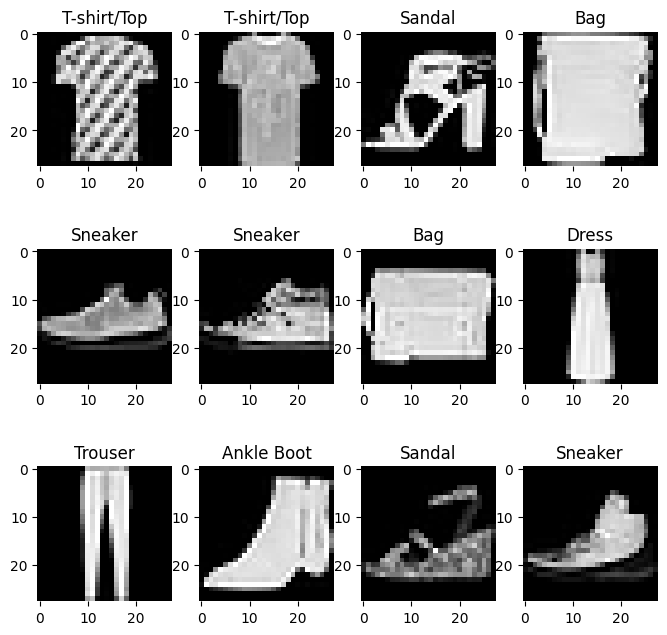

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## get a batch of data
images, labels = next(iter(train_loader))


image_dict = {0:'T-shirt/Top', 1:'Trouser', 2:'Pullover', 3:'Dress',
              4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker',
              8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))

print(images.size())

for i in np.arange(1, 13):
    ax = fig.add_subplot(3,4,i, frameon=False)
    img = images[i][0]
    ax.set_title(image_dict[labels[i].item()])
    plt.imshow(img, cmap='gray')


In [8]:
import torch.nn as nn

class Model(nn.Module):
    ## init function is the constructor and we define all the layers used in our model. 
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        '''
        
        
        '''
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
    
        self.bn1 = nn.BatchNorm2d(16)
    
    
        self.relu1 = nn.ReLU()
    
    
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    
    
        self.bn2 = nn.BatchNorm2d(32)
    
  
        self.relu2 = nn.ReLU()
    
    
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
    
    
        self.bn3 = nn.BatchNorm2d(64)
    
    
        self.relu3 = nn.ReLU()
    
    
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    
        self.fc = nn.Linear(64*3*3, num_classes)
        
    def forward(self, x):
        # We will start with feeding the data to the first layer. 
        # We take the output x and feed it back to the next layer 
        x = self.conv1(x)
        x = self.bn1(x)
       
        x = self.relu1(x)
        x = self.maxpool1(x)
    
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
    
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
    
        x = self.flatten(x)
        x = self.fc(x)
        
        
        return x
    
    # Note that before the fully connected(fc) layer, the output is a feature map with size (N,C,H,W)
    # but a fully connected layers expects a input of size (N, dimension). Therefore, before passing the output of
    # maxpool layer to the fc layer, we must first flatten the output of previous layer to a size (N,C*H*W) 
    # and then pass it to the fully connected layer, like x = x.flatten(x)
    
    def flatten(self, x):
        N, C, H, W = x.size()
        #reshape x to (N, C*H*W) 
        
        
        x = x.view(N, -1)
        
        
        return x
        
        
    

In [9]:

# The testcase only tests the input and output dimensions
# The Model object is initialized by providing num_classes as input 
# The network takes input Tensors of dimensions (B,1,28,28), where B is arbitrary batch_size, 
#    1 is the number of channels in the grayscale image and 28 is image size
# The output of the network is Tensor of dimensions (B,10) where 10 is the num_classes

model = Model(num_classes=10)
test_input1 = torch.randn(16,1,28,28)
out1 = model(test_input1)
test_input2 = torch.rand(20,1,28,28)
out2 = model(test_input2)




In [10]:
# Setting up a few learning parameters
learning_rate = 1e-2
decayRate = 0.999
epochs = 5
number_of_classes = 10

In [11]:
## First we will define an instance of the model to train
model = Model(num_classes=number_of_classes)
print(model)

#Move the model to the gpu if is_cuda
if is_cuda:
  model = model.cuda()

# define the loss 'criterion' as nn.CrossEntropyLoss() object
criterion = nn.CrossEntropyLoss()


# Initialize the Adam optimizer for the model.parameters() using the learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# This is the learning rate scheduler. It decreases the learning rate as we approach convergence
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

# optimizer = None

Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)


In [12]:
out = torch.FloatTensor([[0.1,0.8,0.05,0.05]])
true = torch.LongTensor([1])
assert criterion(out, true), 0.8925

In [13]:
## training loop 

## Number of epochs the model runs

def train_model(epochs=25, validate=True):
    '''
    A function to train the model on the dataset and returns the trained model, training loss and
    validation loss for every epoch.
    
    Inputs:
        epochs: Number of times the model should be trained on the whole data.
        validate: A boolean parameter that validates on validation data.
        
    Outputs:
        model: The model trained for specified number of epochs
        training loss: A list of training losses computed for every epoch.
        validation loss: A list of validation losses computed for every epoch.
    
    '''
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        # Iterate through the batches in the data
        training_loss = 0.0
        validation_loss = 0.0
        
        # Move the images and labels to the gpu by checking is_cuda
        # Extract outputs by passing images through the model 
        # estimate loss using criterion(.) with 'outputs' and 'labels'
        # clear the gradients with .zero_grad()
        # Estimate gradients using .backward()
        # update model with .step()
        # update learning_rate with with a .step using my_lr_scheduler
        # add loss to training_loss
        model.train()
        itr = 0
        for (images,labels)  in train_loader:
            
            if is_cuda:
                images, labels = images.cuda(), labels.cuda()
            
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            training_loss += loss.item()

            
            if itr%100 == 0:
                print('Epoch %d/%d, itr = %d, Train Loss = %.3f, LR = %.3E'\
                      %(epoch, epochs, itr, loss.item(),optimizer.param_groups[0]['lr']))
            itr += 1
        train_loss.append(training_loss/len(train_loader))
        print('------------------------------------------------')
        
        # During validation we do not update gradients. We set model to eval()
        # Move images and labels to gpu if is_cuda
        # get 'outputs' using model and images
        # estimate loss using criterion(.) with 'outputs' and 'labels'
        # add loss to 'validation_loss'
        if validate:
            model.eval()
            with torch.no_grad():
                itr = 0
                for (images,labels)  in valid_loader:
                    # your code here
                    if is_cuda:
                        images, labels = images.cuda(), labels.cuda()

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    validation_loss += loss.item()
                    
                    if itr%100 == 0:
                        print('Epoch %d/%d, itr = %d, Val Loss = %.3f, LR = %.3E'\
                              %(epoch, epochs, itr, loss.item(),optimizer.param_groups[0]['lr']))
                    itr += 1
                val_loss.append(validation_loss/len(valid_loader))
                print('################################################')
                
    return model, train_loss, val_loss
                

In [14]:
start = time.time()
trained_model, train_loss, val_loss = train_model(epochs, validate=True)
end = time.time()
print('Time to train in seconds ',(end - start))

Epoch 0/5, itr = 0, Train Loss = 2.447, LR = 1.000E-02
Epoch 0/5, itr = 100, Train Loss = 0.507, LR = 1.000E-02
Epoch 0/5, itr = 200, Train Loss = 0.499, LR = 1.000E-02
Epoch 0/5, itr = 300, Train Loss = 0.525, LR = 1.000E-02
Epoch 0/5, itr = 400, Train Loss = 0.372, LR = 1.000E-02
Epoch 0/5, itr = 500, Train Loss = 0.426, LR = 1.000E-02
Epoch 0/5, itr = 600, Train Loss = 0.405, LR = 1.000E-02
Epoch 0/5, itr = 700, Train Loss = 0.409, LR = 1.000E-02
------------------------------------------------
Epoch 0/5, itr = 0, Val Loss = 0.284, LR = 1.000E-02
Epoch 0/5, itr = 100, Val Loss = 0.608, LR = 1.000E-02
################################################
Epoch 1/5, itr = 0, Train Loss = 0.200, LR = 1.000E-02
Epoch 1/5, itr = 100, Train Loss = 0.156, LR = 1.000E-02
Epoch 1/5, itr = 200, Train Loss = 0.343, LR = 1.000E-02
Epoch 1/5, itr = 300, Train Loss = 0.196, LR = 1.000E-02
Epoch 1/5, itr = 400, Train Loss = 0.292, LR = 1.000E-02
Epoch 1/5, itr = 500, Train Loss = 0.278, LR = 1.000E-02


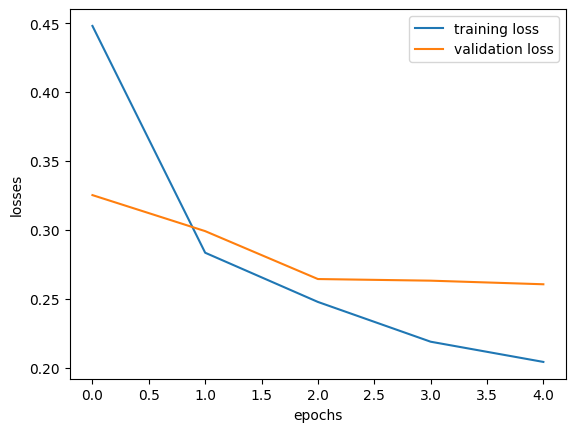

In [16]:
# Plot the losses
it = np.arange(epochs)
plt.plot(it, train_loss, label='training loss')
plt.plot(it, val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='upper right')
plt.show()

In [17]:
## Testing Loop

def evaluate_model(model, loader):
    '''
    A function to test the trained model on the dataset and print the accuracy on the testset.
    
    Inputs:
        model: Trained model
        loader: train_loader or test_loader
        
    outputs:
        accuracy. returns the accuracy of prediction
    '''
    model.eval()
    with torch.no_grad():
        correct = 0
        total_samples = 0
        for images, labels in loader:
            ## Move the images and labels to gpu if is_cuda 
            ## Get the output of the model by passing images as input to the model
            ## estimate the index of the highest output in each row, that is the predicted label 
            ## There is no need for softmax if the goal is to merely identify the predicted category
            ## compare predictions with ground truth for number of correct samples
        
            if is_cuda:
                images, labels = images.cuda(), labels.cuda()
                
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            correct += (predicted == labels).sum().item()
            
            
            total_samples += labels.size(0)
        
        accuracy = correct/total_samples*100
        print("Total Accuracy on the Input set: {} %".format(accuracy))
        return accuracy

In [18]:
# With these settings, obtained 95% train and 91% test accuracy
tr_acc = evaluate_model(model, train_loader)
ts_acc = evaluate_model(model, test_loader)
print('Train Accuracy = %.3f'%(tr_acc))
print('Test Accuracy = %.3f'%(ts_acc))

Total Accuracy on the Input set: 93.35833333333333 %
Total Accuracy on the Input set: 90.25999999999999 %
Train Accuracy = 93.358
Test Accuracy = 90.260


In [19]:
# test cases for test accuracy > 90%


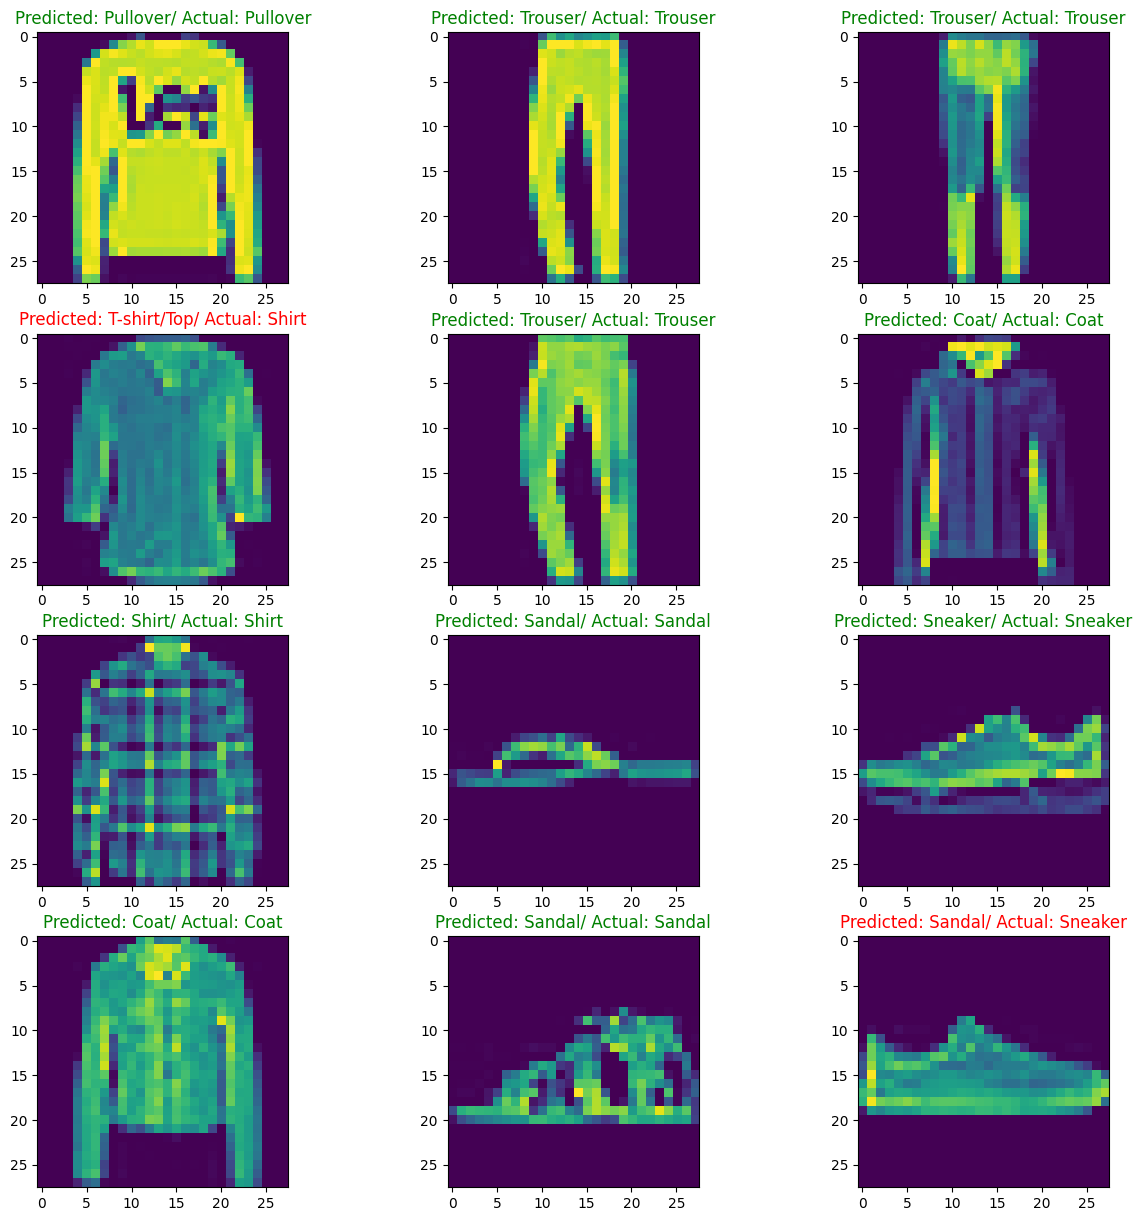

In [21]:
## Visualize the test samples with predicted output and true output
images, labels = next(iter(test_loader))
# images = images.numpy()
if is_cuda:
  images = images.cuda()
  labels = labels.cuda()

out = model(images)
_, preds = torch.max(out, dim=1)

images = images.to('cpu').numpy()

fig = plt.figure(figsize=(15,15))
for i in np.arange(1, 13):
    ax = fig.add_subplot(4, 3, i)
    plt.imshow(images[i][0])
    ax.set_title("Predicted: {}/ Actual: {}".format(image_dict[preds[i].item()], image_dict[labels[i].item()]), 
                color=('green' if preds[i] == labels[i] else 'red'))